<a href="https://colab.research.google.com/github/danieljaouen/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module3-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [9]:
import numpy as np
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [3]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [14]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  # time_on_site = random.uniform(10, 600)
  time_on_site = np.random.normal(9.4 * 60, 3 * 60)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = np.random.normal(7.5 * 60, 2 * 60)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=True, time_on_site=545.5707350449691, mobile=True), User(purchased=False, time_on_site=423.37160747329295, mobile=True), User(purchased=True, time_on_site=730.0421494924008, mobile=True), User(purchased=False, time_on_site=303.54885314503576, mobile=True), User(purchased=True, time_on_site=728.4170290301463, mobile=True), User(purchased=True, time_on_site=304.5681691925415, mobile=True), User(purchased=True, time_on_site=345.11809152456937, mobile=True), User(purchased=False, time_on_site=423.96923325535846, mobile=True), User(purchased=True, time_on_site=580.431937898143, mobile=True), User(purchased=False, time_on_site=588.6713452934126, mobile=False)]


In [15]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,True,545.570735,True
1,False,423.371607,True
2,True,730.042149,True
3,False,303.548853,True
4,True,728.417029,True


In [18]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,15.935697695253566,78.31509679507968,92.0102814191236,99.79666436151865,111.58639769667474,126.16833735707911,131.8629985545884,153.81178065012693,153.92371880298873,161.59729829021802,168.02465076727054,170.84295192751398,174.48427052560436,179.19344050819217,180.32536017543003,183.11016962132578,183.37585885280782,192.425122541449,194.59978085596342,200.11799333092847,204.22638384475584,207.83838637368763,210.2484717034127,211.08326267448396,212.46262442086294,213.8499986115811,220.862710437654,223.51276215230746,227.70540223250978,228.14887818197667,233.35446142676287,235.12617278511624,238.15034830467172,238.33631733530916,241.59475740323967,243.30165566108266,244.01023124757376,244.09186485612557,244.21538901235846,245.5120012632883,...,774.6454036971807,775.7356879157926,778.8576316608203,778.9436525891203,779.6296599257927,786.3265761115016,794.9065234722276,803.9958786882426,812.1930438038582,819.8830829524225,820.2708664140578,823.6173481277432,824.8903310959879,825.196203555512,825.326467628611,825.759910304681,827.4684841224959,828.6853709081392,829.4221316637136,831.6048356749095,836.907236691433,842.5867798564077,843.6839610763515,849.73085099544,851.7855688991185,852.3351998136798,854.5772290229546,855.0829147022716,857.168133268198,860.7915113847998,861.5166076026131,863.8784816762457,868.8090338036843,868.8197145821707,934.6155382022419,944.550779233967,947.7628760567877,1031.0286211945547,1060.2918179137164,1128.6244848973279
purchased,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,0,1,1,1,1,1,0,0,0,1,1,1,1,1,0,1,0,1,1,0,0,1,1,0,1,1,1,1,1,0,1,0,1,1,0,0,...,0,1,0,0,1,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0
True,0,0,0,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,1,...,1,0,1,1,0,0,0,1,1,1,1,0,1,1,0,0,1,0,1,1,0,1,1,1,1,1,1,1,0,0,1,0,1,1,1,0,1,1,1,1


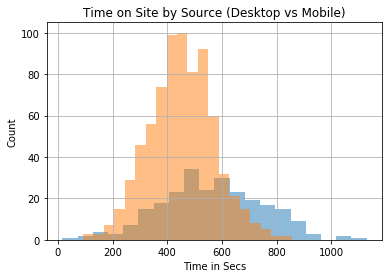

In [21]:
import matplotlib.pyplot as plt

user_data.groupby('mobile').time_on_site.hist(bins=20, alpha=0.5)
plt.title('Time on Site by Source (Desktop vs Mobile)')
plt.ylabel('Count')
plt.xlabel('Time in Secs')
plt.show()

In [0]:
user_data[user_data['time_on_site'] < 0]
user_data.loc[user_data['time_on_site'] < 0.0, 'time_on_site'] = 0.0

In [24]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site,,
"(14.823, 238.473]",24,10
"(238.473, 461.011]",222,206
"(461.011, 683.549]",175,276
"(683.549, 906.087]",20,61
"(906.087, 1128.624]",1,5


In [25]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(14.823, 238.473]",0.054299,0.017921
"(238.473, 461.011]",0.502262,0.369176
"(461.011, 683.549]",0.395928,0.494624
"(683.549, 906.087]",0.045249,0.109319
"(906.087, 1128.624]",0.002262,0.008961


In [26]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.508,0.42
True,0.492,0.58


In [27]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']], normalize='columns')

purchased               False               True           
mobile                  False     True      False     True 
time_on_site                                               
(14.823, 238.473]    0.078740  0.044444  0.000000  0.022989
(238.473, 461.011]   0.377953  0.552381  0.121951  0.439080
(461.011, 683.549]   0.401575  0.393651  0.487805  0.496552
(683.549, 906.087]   0.133858  0.009524  0.349593  0.041379
(906.087, 1128.624]  0.007874  0.000000  0.040650  0.000000

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)